# Train a Pointcloud classifier

> **Skill level:** _Beginner_

Kaolin makes 3D deep learning easy, by providing all the _hard_/_tricky_ parts of coding up a 3D DL application. To get a feel for how easy training classifiers on 3D data has become, here's a quick demo.

In this tutorial, we will train a _pointcloud_ classifier, in about five lines of code!

For those who are new to pointclouds, here's how they look like.

<p align="center">
    <img src="../../assets/airplane_points.png">
</p>

We will use the `ModelNet10` dataset for the remainder of this tutorial. The remainder of this tutorial will be broken down into the following components.

- [Downloading ModelNet10](#downloading-modelnet10)
- [DataLoading](#dataloading)
- [Training the pointcloud classifier](#training-the-pointcloud-classifier)
- [Bells and whistles](#bells-and-whistles)

## Downloading ModelNet10

Note that the ModelNet10 dataset is provided ONLY for the convenience of academic research. Should you choose to download it, you must adhere to the original terms and copyright notice of the dataset. For convenience, we reproduce the original copyright from the dataset creators.

```
**Copyright**

All CAD models are downloaded from the Internet and the original authors hold the copyright of the CAD models. The label of the data was obtained by us via Amazon Mechanical Turk service and it is provided freely. This dataset is provided for the convenience of academic research only.
```

The ModelNet10 (10-class subset) dataset is available on the [Princeton ModelNet page](https://modelnet.cs.princeton.edu/). On this page, navigate to the ModelNet10 download link to obtain the dataset. We assume that it is unzipped and extracted to a location `MODELNET_DIRECTORY`.

## Warm-up

Before all the fun-stuff begins, let us import all necessary functions from `kaolin` and `torch`. A bit more on what the following modules do will become clear as we progress.

In [1]:
import torch
from torch.utils.data import DataLoader
import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet
from kaolin.models.PointNet import PointNetClassifier
import kaolin.transforms as tfs
from torchvision.transforms import Lambda

from tqdm.notebook import tqdm

   No module named 'nuscenes'
   None


Traceback (most recent call last):
  File "/home/jlafleche/Projects/kaolin_gitlab/kaolin/datasets/__init__.py", line 11, in <module>
    from .nusc import NuscDetection
  File "/home/jlafleche/Projects/kaolin_gitlab/kaolin/datasets/nusc.py", line 21, in <module>
    from nuscenes.utils.geometry_utils import transform_matrix
ModuleNotFoundError: No module named 'nuscenes'


## Dataloading

Kaolin provides convenience functions to load popular 3D datasets (of course, ModelNet10). Assuming you have [installed Kaolin](../../README.md#installation-and-usage), fire up your favourite python interpreter, and execute the following commands.

To start, we will define a few important parameters:

In [2]:
modelnet_path = 'path/to/ModelNet10/'
categories = ['chair', 'sofa']
num_points = 1024
device = 'cuda'
workers = 8

# Training parameters
batch_size = 12
learning_rate = 1e-3
epochs = 10

The `model_path` variable will hold the path to the ModelNet10 dataset. We will use the `categories` variable to specify which classes we want to learn to classify. `num_points` is the number of points we will sample from the mesh when transforming it to a pointcloud. Finally, we will disable multiprocessing and memory pinning if we are using CUDA for our transform operations.

In [3]:
def to_device(inp):
    inp.to(device)
    return inp

transform = tfs.Compose([
    to_device,
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])

num_workers = 0 if device == 'cuda' else workers
pin_memory = device != 'cuda'

This command defines a `transform` that first converts a mesh representation to a pointcloud and then _normalizes_ it to be centered at the origin, and have a standard deviation of 1. Much like images, 3D data such as pointclouds need to be normalized for better classification performance.

In [4]:
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform),
                          batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=pin_memory)

Phew, that was slightly long! But here's what it does. It creates a `DataLoader` object for the `ModelNet10` dataset. In particular, we are interested in loading only the `chair` and `sofa` categories. The `split='train'` argument indicates that we're loading the 'train' split. The `rep='pointcloud'` loads up meshes and converts them into pointclouds. The `transform=norm` applies a normalizing transform to each pointcloud. The other parameters are fairly easy to decipher.

Similarly, the validation dataset can be loaded up as follows.

In [5]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform),
                        batch_size=batch_size, num_workers=num_workers,
                        pin_memory=pin_memory)

## Setting up our model, optimizer and loss criterion

In [6]:
model = PointNetClassifier(num_classes=len(categories)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

## Training the pointcloud classifier

The following line of code will train and validate a _PointNet_ classifier, which is probably the simplest of pointcloud neural architectures.

In [7]:
for e in range(epochs):
    print(f'{"":-<10}\nEpoch: {e}\n{"":-<10}')

    train_loss = 0.
    train_accuracy = 0.

    model.train()
    for batch_idx, (data, attributes) in enumerate(tqdm(train_loader)):
        category = attributes['category'].to(device)
        pred = model(data)
        loss = criterion(pred, category.view(-1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute accuracy
        pred_label = torch.argmax(pred, dim=1)
        train_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Train loss:', train_loss / len(train_loader))
    print('Train accuracy:', train_accuracy / len(train_loader))

    val_loss = 0.
    val_accuracy = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, attributes) in enumerate(tqdm(val_loader)):
            category = attributes['category'].to(device)
            pred = model(data)
            loss = criterion(pred, category.view(-1))
            val_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(pred, dim=1)
            val_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Val loss:', val_loss / len(val_loader))
    print('Val accuracy:', val_accuracy / len(val_loader))

----------
Epoch: 0
----------



Train loss: 0.049577866860875106
Train accuracy: 0.984520782496183



Val loss: 1.996058419638988
Val accuracy: 0.5759803937638507
----------
Epoch: 1
----------



Train loss: 0.025925380295766375
Train accuracy: 0.9910941492510206



Val loss: 0.02229202354689786
Val accuracy: 0.9852941211532144
----------
Epoch: 2
----------



Train loss: 0.026611668057295403
Train accuracy: 0.990458017542162



Val loss: 0.010962185896192644
Val accuracy: 0.9950980403844047
----------
Epoch: 3
----------



Train loss: 0.0489288965736219
Train accuracy: 0.9910941487960233



Val loss: 0.007010548280531485
Val accuracy: 0.9950980403844047
----------
Epoch: 4
----------



Train loss: 0.026334123992323804
Train accuracy: 0.9942748100702999



Val loss: 0.03581363566028064
Val accuracy: 0.9852941211532144
----------
Epoch: 5
----------



Train loss: 0.017674359473073678
Train accuracy: 0.9968193391807206



Val loss: 0.0739082695879193
Val accuracy: 0.9852941211532144
----------
Epoch: 6
----------



Train loss: 0.03026853118948052
Train accuracy: 0.9917302818698738



Val loss: 0.01342605816299671
Val accuracy: 0.9950980403844047
----------
Epoch: 7
----------



Train loss: 0.05086674511309123
Train accuracy: 0.9923664131237351



Val loss: 0.0715277231133336
Val accuracy: 0.975490201922024
----------
Epoch: 8
----------



Train loss: 0.026940815879666524
Train accuracy: 0.9917302814148764



Val loss: 0.009962925690000275
Val accuracy: 1.0
----------
Epoch: 9
----------



Train loss: 0.011543766358538037
Train accuracy: 0.995547074853009



Val loss: 0.0008934929042772958
Val accuracy: 1.0


## Visualizing the results

We will create a new dataloder which will load the same data as our previous val_loader but with shuffling, and take a sample batch.

In [8]:
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                  split='test',transform=transform),
                        shuffle=True, batch_size=15)

data, attr = next(iter(test_loader))
data = data.to('cuda')
labels = attr['category'].to('cuda')
preds = model(data)
pred_labels = torch.max(preds, axis=1)[1]

Next, we setup a plot to visualize the pointcloud, groundtruth label and our prediction using a small utility function. Here we've also colour-coded the results - green for correct and red for incorrect.

<IPython.core.display.Javascript object>


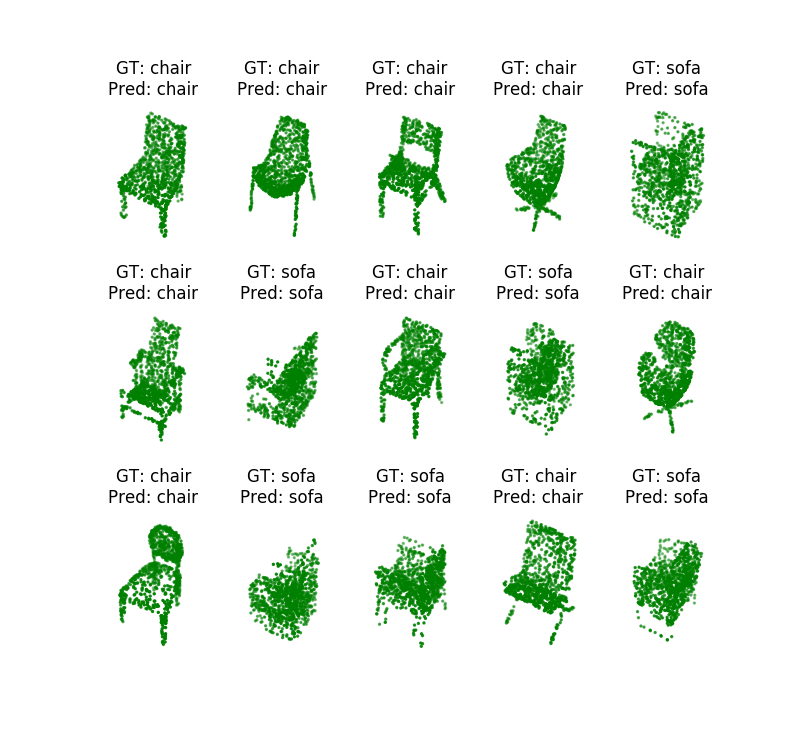

In [9]:
from utils import visualize_batch

%matplotlib notebook

visualize_batch(data, pred_labels, labels, categories)

Looks like we have a working classifier!

That's it, you've trained your first 3D classifier on pointcloud data using Kaolin!!

## Bells and whistles

You can train on other categories by simply changing the `categories` argument passed to the `ModelNet10` dataset object. For example, you can add a `bed` class by running
```python
dataset = ModelNet('/path/to/ModelNet10', categories=['chair', 'sofa', 'bed'],
                   split='train', rep='pointcloud', transform=norm, device='cuda:0')
```

You can also configure the parameters of the `PointNetClassifier` to your liking. For a more detailed explanation, refer to the documentation of the `PointNetClassifier` class.

Furthermore, you can experiment with different configurations of learning rate, optimizer, training duration, and more.